In [1]:
# The first time you run this cell, it takes about 1 minute forty seconds on my Apple M2 Chip Macbook Air to complete... sorry about that...
from queue import PriorityQueue
import random
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

class KNearesetNeighborsTrainer:
    """This class takes in data as a pandas data frame along with a block size and parameter for the k nearest neighbors, 
    """
    
    def __init__(self, file_name: str, delimiter: str, id_column_name: str, classification_column_name: str, k : int, n : int):
        """Initialize a KNearestNeighborsTrainer, which takes in a data frame of all its points, a parameter k for its so-named training algorithm, and the number of different blocks it should partition its data into

        Args:
            file_name (str): The file from which to read in data
            k (int): The number of closest other points used to guess if a certain point belongs to a given classification
            n (int): The number of different blocks to partition the training points into
        """
        # Record a couple attributes
        self.id_column_name = id_column_name
        self.classification_column_name = classification_column_name

        # First let's read in our data
        read_from = open(file_name, "r")
        points_as_strings = read_from.readlines()

        # Let's look at the first line, which reveals the point attributes which are numeric
        header = points_as_strings[0][:-1] # Remember to omit the '\n' character
        attributes = header.split(delimiter)
        class_idx = -1
        id_idx = -1
        numerical_value_indices = []
        for i, attr in enumerate(attributes):
            if attr == classification_column_name:
                class_idx = i
            elif attr == id_column_name:
                id_idx = i
            else:
                numerical_value_indices.append(i)
        points_as_strings = points_as_strings[1:]

        self.data_length = len(points_as_strings)
        read_from.close()
        self.raw_data_array = np.zeros(shape=(self.data_length,len(numerical_value_indices)))
        self.labels = []
        self.names = []
        self.points_as_dicts = []
        for block_idx, point_string in enumerate(points_as_strings):
            # First omit the '\n' character in each row of data corresponding to a point
            point_attributes = point_string[:-1].split(delimiter)

            # Record the unique id and class of this point
            self.labels.append(int(point_attributes[class_idx]))
            self.names.append(point_attributes[id_idx])

            # Record all numerical elements of the points 
            for i, idx in enumerate(numerical_value_indices):
                try:
                    self.raw_data_array[block_idx][i] += float(point_attributes[idx])
                except:
                    a = 3
            
            # Turn this point into a dictionary
            point_as_dict = {}
            point_as_dict[id_column_name] = self.names[block_idx]
            point_as_dict[classification_column_name] = self.labels[block_idx]
            self.points_as_dicts.append(point_as_dict)
 
        # Normalize the data array along each axis:
        self.normalized_data_array = normalize(X=self.raw_data_array, norm='l2', axis=1, copy=True)

        # K nearest points parameter
        self.k = k
        
        # To break the data up into training blocks
        self.split_data = []
        block_size = len(points_as_strings)//n
        self.block_all_trained = []
        self.block_error_trained = []
        # We want to break up into blocks randomly
        indices = random.sample(range(0, self.data_length), self.data_length)
        rand_indx_posn = 0
        for i in range(n):
            # In case our number of blocks does not evenly divide our data, the last block of data may have fewer elements
            this_block_size = self.data_length - i*block_size if i == n-1 else block_size
            self.split_data.append([])
            while len(self.split_data[i]) < this_block_size:
                next_random_idx = indices[rand_indx_posn]
                rand_indx_posn += 1
                next_random_point = self.points_as_dicts[next_random_idx]
                self.split_data[i].append(next_random_point)
            self.block_all_trained.append(False)
            self.block_error_trained.append(False)
            
        # For each data point, store its actual label keyed by its id
        self.values = {}
        
        # Store our model's prediction of each point's label by that point's id
        self.predictions = {}
        
        # Each block of points stores a dictionary that stores a {point_name: closest_points_priority_queue} dictionary for all points in that block
        self.block_queues = [{} for _ in range(n)] # Priority queues for storing ALL points
        self.error_block_queues = [{} for _ in range(n)] # Priority queues for storing ERROR points
        
        # Each block of points stores a set of miss-classified points from OTHER blocks which it can use to see which points to add into its points' queues during error-training
        self.miss_classified = [set() for _ in range(n)]
        
        # This dictionary maps point id to that point's vector
        point_vectors = {}
        
        # Record all of our points
        self.distances = {} # For any two points, know their distances
        self.used_in_queue = {} # For any two points, know if each has been used in the queue of the other
        for index, row in enumerate(self.points_as_dicts):
            self.values[row[id_column_name]] = row[classification_column_name]
            point_vectors[row[id_column_name]] = self.normalized_data_array[index]
            self.predictions[row[id_column_name]] = None
            self.distances[row[id_column_name]] = {}
            self.used_in_queue[row[id_column_name]] = {}

        print("Data points processed! The next step is O(n^2) so apologies for the wait...")

        # Record each point distance and record if each point has used each respective other point in its training priority queue
        for name_1 in self.distances:
            for name_2 in self.distances:
                if name_1 != name_2:
                    self.distances[name_1][name_2] = np.linalg.norm(point_vectors[name_1] - point_vectors[name_2])
                    self.used_in_queue[name_1][name_2] = False

        print("Training structure set up!")
    
    class __DistancedNode:
        """This inner class is an object that has two attributes - a position label and a given distance from that position from a certain other point that this class does not need to know about
        """
        def __init__(self, id : str, dist : float):
            self.id = id
            self.dist = dist
            
        def __gt__(self, other):
            return self.dist > other.dist

        def __eq__(self, other):
            return self.dist == other.dist
        
        def __lt__(self, other):
            return self.dist < other.dist
                    
    def __train_store_all(self, i : int):
        """Perform the 'store all' variant of the k-nearest-neighbors training on the ith block of data

        Args:
            i (int): index for the training block
        """
        # HERE'S where we make our heaps, because only values from OTHER blocks go into the priority queues
        # NOTE - we're going to use dynamic programming to avoid making our priority queues more than once
        # NOTE (again) - this training method is 'trivial' because once it is performed a single time it never improves in terms of making predictions - we only need to make and add to priority queues once
        if not self.block_all_trained[i]:
            self.block_all_trained[i] = True
            for j, block in enumerate(self.split_data):
                if i != j:
                    # Block j is NOT our current block that we're training, so the points in block j ARE considered to be neighbors of the points in our current block (block i)
                    for row_1 in self.split_data[i]:
                        # For each point in our current block i, give that point a priority queue of other closest points
                        name_1 = row_1[self.id_column_name]
                        self.block_queues[i][name_1] = PriorityQueue()
                        for row_2 in block:
                            name_2 = row_2[self.id_column_name]
                            self.block_queues[i][name_1].put(self._DistancedNode(id=name_2, dist=self.distances[name_1][name_2]))
        
        # Now that the queues are completed, train on them
        self.__train(block_idx=i, queue_list=self.block_queues)
        
        
    def __train_store_errors(self, i : int):
        """Perform the 'store errors' variant of the k-nearest-neighbors training on the ith block of data

        Args:
            i (int): index for the training block
        """
        # We're still going to be making priority queues - initially putting k other points in said queues from EACH classification, but we're only going to be adding to these queues when a point is mis-classified
        if not self.block_error_trained[i]:
            # We need to give each point in this block k other points from each classification for its queue of closest points
            self.block_error_trained[i] = True
            for point_row in self.split_data[i]:
                this_name = point_row[self.id_column_name]
                self.error_block_queues[i][this_name] = PriorityQueue()
                points_in_queue = {}
                for j, block in enumerate(self.split_data):
                    if j != i:
                        # Only look at points from other blocks of data
                        for row in block:
                            other_name = row[self.id_column_name]
                            other_value = row[self.classification_column_name]
                            if not self.used_in_queue[this_name][other_name]:
                                if other_value not in points_in_queue.keys():
                                    points_in_queue[other_value] = 1
                                elif points_in_queue[other_value] < self.k:
                                    points_in_queue[other_value] += 1
                                    self.used_in_queue[this_name][other_name] = True
                                    self.error_block_queues[i][this_name].put(self.__DistancedNode(id=other_name, dist=self.distances[this_name][other_name]))
        
        # That's an initialization of the priority queue for each point in this block completed
        # Now we need to add all mis-classified points from different blocks into each point's queue from this block
        for point_row in self.split_data[i]:
            this_name = point_row[self.id_column_name]
            for j, miss_classified_in_block in enumerate(self.miss_classified):
                if j != i:
                    for other_name in miss_classified_in_block:
                        if not self.used_in_queue[this_name][other_name]:
                            self.used_in_queue[this_name][other_name] = True
                            self.error_block_queues[i][this_name].put(self.__DistancedNode(id=other_name, dist=self.distances[this_name][other_name]))
    
        # Now that the queues are complete, train on them
        self.__train(block_idx=i, queue_list=self.error_block_queues)
        
        # Since this is error training, every point in this block which we have miss-classified, we mark as such so that points from other blocks can throw each miss-classified point from this block into their queue
        for point_row in self.split_data[i]:
            this_name = point_row[self.id_column_name]
            if self.predictions[this_name] != self.values[this_name]:
                self.miss_classified[i].add(this_name)
            elif this_name in self.miss_classified[i]:
                self.miss_classified[i].remove(this_name)
    
    def __train(self, block_idx: int, queue_list: list[PriorityQueue]):
        """Given a list of queues by the block, and the right block index, this algorithm empties (and replaces) k points from each queue to classify the queue's respective point

        Args:
            block_idx (int): The index of the block of points we are classifying
            queue_list (list[PriorityQueue]): The list of all queues by the block - we will only be taking the point queues from block 'block_idx'
        """
        # Each point has an UPDATED priority queue of other points where the closest point to this point will come first
        for row in self.split_data[block_idx]:
            name = row[self.id_column_name]
            closest_nodes = queue_list[block_idx][name]
            prediction_counts = {}
            empty_into = []
            # Empty k points from this point's queue of closest points
            while len(empty_into) < self.k:
                next_closest = closest_nodes.get()
                empty_into.append(next_closest)
                value = self.values[next_closest.id]
                if value not in prediction_counts.keys():
                    prediction_counts[value] = 1
                else:
                    prediction_counts[value] += 1
            # Now put those k points back
            for point in empty_into:
                queue_list[block_idx][name].put(point)
                
            # Now see which classification type had the highest count
            record_prediction_count = 0
            record_prediction = -1
            for pred, count in prediction_counts.items():
                if count > record_prediction_count:
                    record_prediction_count = count
                    record_prediction = pred
            self.predictions[name] = record_prediction
        
        print(f"Block {block_idx} done training!")
    
    def train_all(self):
        """Iterate over each block of data that is automatically partitioned in the constructor, and train that block of data using all other blocks of data with the 'store all' KNN algorithm
        """
        acc_test = 0
        for i in range(len(self.split_data)):
            self.__train_store_all(i)
            acc_test += sum([1 for row in self.split_data[i] if (self.predictions[row[self.id_column_name]] == row[self.classification_column_name])]) / len(self.split_data[i])
        print(acc_test/len(self.split_data))
    
    def train_error(self):
        """Iterate over each block of data that is automatically partitioned in the constructor, and train that block of data using all other blocks of data with the 'store error' KNN algorithm
        """
        acc_test = 0
        for i in range(len(self.split_data)):
            self.__train_store_errors(i)
            acc_test += sum([1 for row in self.split_data[i] if (self.predictions[row[self.id_column_name]] == row[self.classification_column_name])]) / len(self.split_data[i])
        print(acc_test/len(self.split_data))
    
    def plot_predictions(self):
        # If we do not have two-dimensional data, do not plot
        if self.raw_data_array.shape[1] != 2:
            return

        # Plot our data with its actual classifications
        fig, ax = plt.subplots()
        scatter = ax.scatter(self.raw_data_array[:, 0], self.raw_data_array[:, 1], c=self.labels)
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        legend = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend)
        plt.title("Model Data")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()
        fig.clear()
        
        # Now do the dame with predictions
        fig, ax = plt.subplots()
        scatter = ax.scatter(self.raw_data_array[:, 0], self.raw_data_array[:, 1], c=[self.predictions[name] for name in self.names])
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        # legend = ax.legend(*scatter.legend_elements(),
        #                     loc="lower left", title="Classes")
        # ax.add_artist(legend)
        plt.title("Model Prediction")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.show()
        fig.clear()

Data points processed! The next step is O(n^2) so apologies for the wait...
Training structure set up!
Block 0 done training!
Block 1 done training!
Block 2 done training!
Block 3 done training!
Block 4 done training!
0.7459999999999999


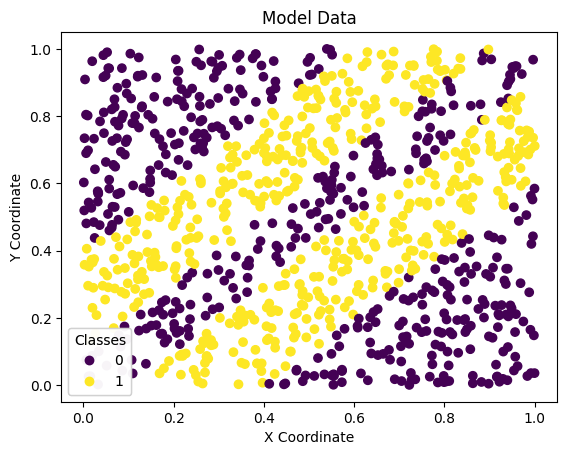

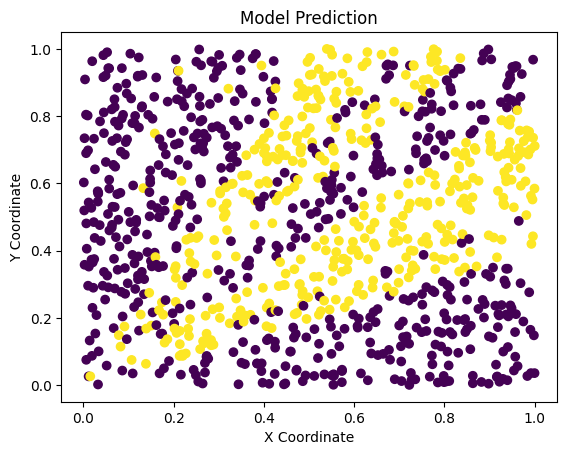

In [2]:
# This takes about five seconds to run on my computer.
trainer = KNearesetNeighborsTrainer(file_name="labeled-examples", delimiter=" ", id_column_name="id", classification_column_name="class", k=10, n=5)
trainer.train_all()
trainer.plot_predictions()

Data points processed! The next step is O(n^2) so apologies for the wait...
Training structure set up!
Block 0 done training!
Block 1 done training!
Block 2 done training!
Block 3 done training!
Block 4 done training!
0.647


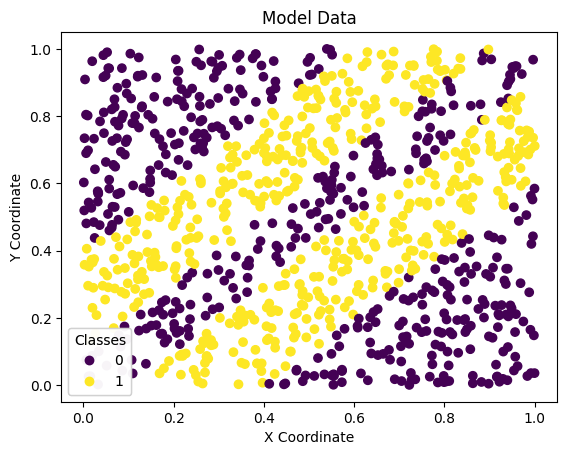

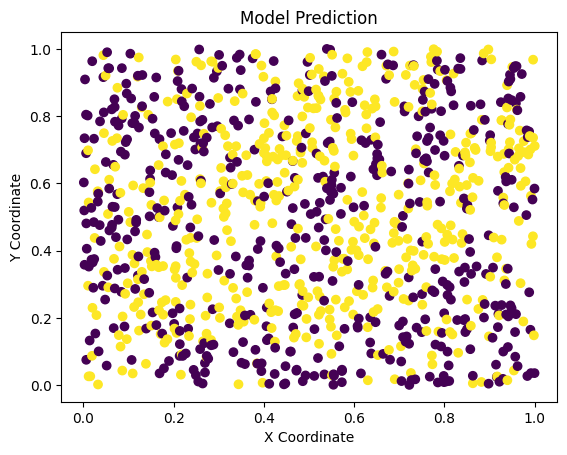

In [3]:
# This takes less time to train because of the lower training complexity - we're talking around three seconds in total on my computer.
trainer = KNearesetNeighborsTrainer(file_name="labeled-examples", delimiter=" ", id_column_name="id", classification_column_name="class", k=10, n=5)
trainer.train_error()
trainer.plot_predictions()

In [4]:
# This completes in a little under three minutes on my Apple M2 Chip Macbook Air...
trainer = KNearesetNeighborsTrainer(file_name="winequality.csv", delimiter=";", id_column_name="\"id\"", classification_column_name="\"type\"", k=10, n=5)
trainer.train_all()

Data points processed! The next step is O(n^2) so apologies for the wait...
Training structure set up!
Block 0 done training!
Block 1 done training!
Block 2 done training!
Block 3 done training!
Block 4 done training!
0.9430539308011425


In [5]:
# Due to lower training complexity, this takes closer to two minutes, but the setup is still O(n^2)...
trainer = KNearesetNeighborsTrainer(file_name="winequality.csv", delimiter=";", id_column_name="\"id\"", classification_column_name="\"type\"", k=10, n=5)
trainer.train_error()

Data points processed! The next step is O(n^2) so apologies for the wait...
Training structure set up!
Block 0 done training!
Block 1 done training!
Block 2 done training!
Block 3 done training!
Block 4 done training!
0.7872339569431699
